# Import supporting package

In [1]:
import lmfit
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt

#test
plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()



In [14]:
# get center of thresholded image
def calc_thresh(data):
    shape = np.shape(data)
    thresh = np.zeros(shape)
    sigma = 0.4

    if len(shape) == 4:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
            for j in range(0, shape[1]):
                thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.3,0,1)

    elif len(shape) == 3:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
                thresh[i] = np.where(blurred[i] < np.max(blurred[i])*0.3,0,1)

    else:
        print("Shape of data is wrong, output is empty")

    return thresh

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen

def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess



def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

# def polylog(power, numerator, order = 15):
#
#     dataShape = numerator.shape
#     numerator = np.tile(numerator, (order, 1))
#     numerator = np.power(numerator.T, np.arange(1, order+1)).T
#
#     denominator = np.arange(1, order+1)
#     denominator = np.tile(denominator, (dataShape[0], 1))
#     denominator = denominator.T
#
#     data = numerator/ np.power(denominator, power)
#
#     return np.sum(data, axis=0)

def polylog_tab(pow, x):
    order = 100
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum

x_int = np.linspace(0, 1.00001, 100000)

poly_tab = polylog_tab(2,x_int)



polylog_int = CubicSpline(x_int, poly_tab)

def thermal(x, x0, amp, sigma):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp/1.643 * polylog_int(res)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1- ((x-x0)/sigma)**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amp * res

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


def polylog(pow, x):
    order = 15
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum


def ThomasFermi_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):

    res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amplitude * res
    # return amplitude * 5 / 2 / np.pi / max(tiny, sigmax * sigmay) * np.where(res > 0, res, 0)


    # return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))
# Set up table for polylog


def polylog2_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    ## Approximation of the polylog function with 2D gaussian as argument. -> discribes the thermal part of the cloud
    return amplitude/1.643  * polylog_int(np.exp( -((x-centerx)**2/(2 * sigmax**2))-((y-centery)**2/( 2 * sigmay**2)) ))



def density_profile_BEC_2d(x, y=0.0, amp_bec=1.0, amp_th=1.0, x0_bec=0.0, y0_bec=0.0, x0_th=0.0, y0_th=0.0,
                           sigmax_bec=1.0, sigmay_bec=1.0, sigma_th=1.0):
    return ThomasFermi_2d(x=x, y=y, centerx=x0_bec, centery=y0_bec,
                          amplitude=amp_bec, sigmax=sigmax_bec, sigmay=sigmay_bec
                          ) + polylog2_2d(x=x, y=y, centerx=x0_th, centery=y0_th,
                                          amplitude=amp_th, sigmax=sigma_th,sigmay=sigma_th)

def cond_frac(results):
    bval = results.best_values
    tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
    N_bec = np.sum(tf_fit)
    fit = fit = density_profile_BEC_2d(X,Y, **bval)
    N_ges = np.sum(fit)
    return N_bec/N_ges

def print_bval(res_s):
    keys = res_s.best_values.keys()
    bval = res_s.best_values
    init = res_s.init_params

    for item in keys:
        print(f'{item}: {bval[item]:.3f}, (init = {init[item].value:.3f}), bounds = [{init[item].min:.2f} : {init[item].max :.2f}] ')
    print('')

def print_bval_bulk(res_):
    shape = np.shape(res_)
    if len(shape) == 2:
        for i in range(shape[0]):
            for j in range(shape[1]):
                print(f'image: {i}, {j}')
                print_bval(res_[i][j])

    if len(shape) == 1:
        for i in range(shape[0]):
            print(f'image: {i}')
            print_bval(res_[i])


In [3]:
# load Brittas data

data = np.zeros((2,11, 1200, 1920))
data[0] = np.load('Data_Britta/OD_ft_flatfield.npy')
data[1] = np.load('Data_Britta/OD_ft_manual.npy')

shape = np.shape(data)

In [4]:
def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1])-4:round(center[i,j,1])+5, :])/9
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])-4:round(center[i,j,0])+5])/9

    return BEC_width_guess

In [53]:
print(np.shape(thresh[i, j, round(center[i,j,1])-4:round(center[i,j,1])+5, :]))

(9, 250)


In [8]:
cut_width = 250
thresh = calc_thresh(data)
center = calc_cen_bulk(thresh)

shape = np.shape(data)
cropOD = np.zeros((shape[0], shape[1], cut_width, cut_width))

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        cropOD[i,j] = data[i,j, round(center[i,j,1]-cut_width/2):round(center[i,j,1]+cut_width/2), round(center[i,j,0]-cut_width/2):round(center[i,j,0]+cut_width/2)]

thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)


In [6]:

cut_width = 250
thresh = calc_thresh(data)
center = calc_cen_bulk(thresh)

shape = np.shape(data)
cropOD = np.zeros((shape[0], shape[1], cut_width, cut_width))
blurred = gaussian_filter(data, sigma=0.4)

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        amax = np.argmax(blurred[i,j])

        center[i,j] = np.unravel_index(amax, (shape[2], shape[3]))
        print(center[i,j])
        print(np.max(data[i,j]))
        print(data[i,j, round(center[i,j,0]), round(center[i,j,1]) ])
        cropOD[i,j] = data[i,j, round(center[i,j,0]-cut_width/2):round(center[i,j,0]+cut_width/2), round(center[i,j,1]-cut_width/2):round(center[i,j,1]+cut_width/2)]

thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)

[1081.  481.]
0.32106129452561555
-0.03579800587577903


type: could not broadcast input array from shape (244,250) into shape (250,250)

In [66]:
print(BEC_width_guess[1,7])


[24. 22.]


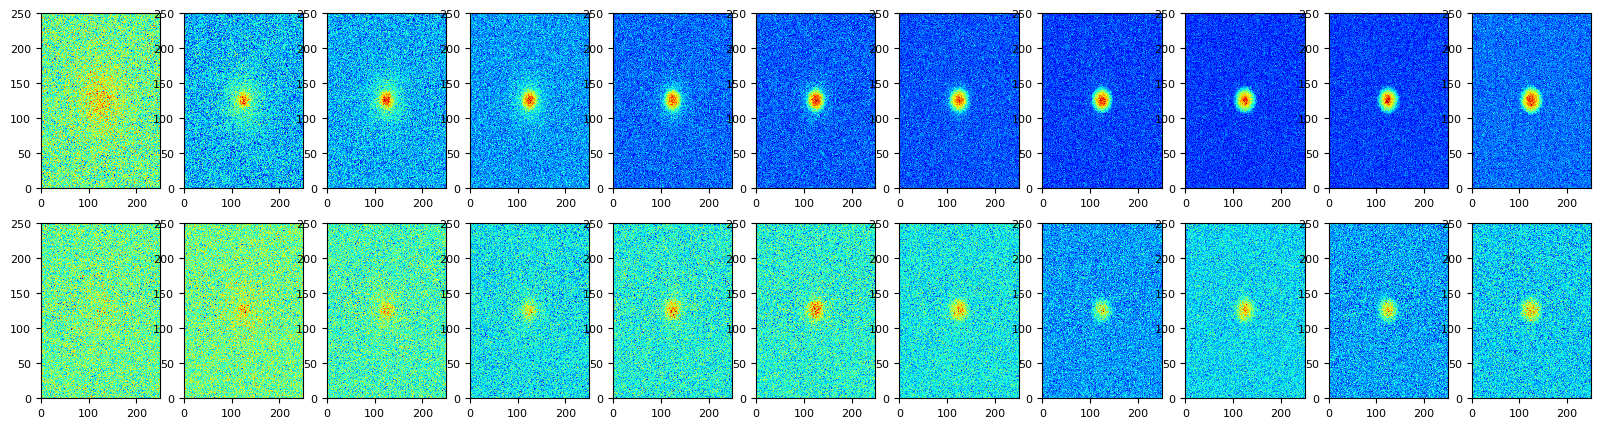

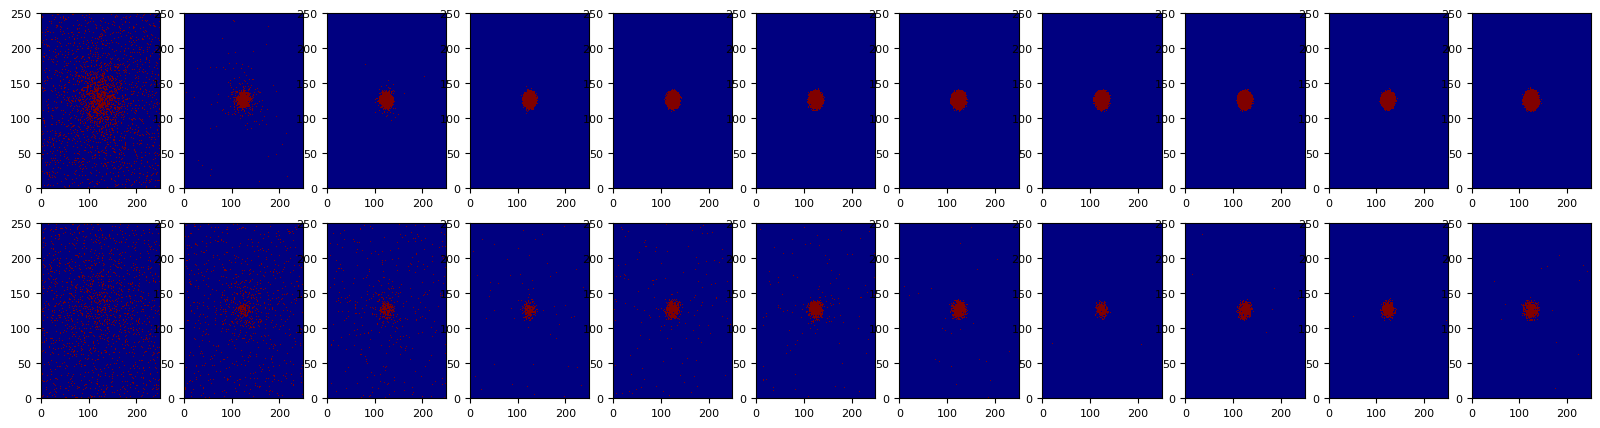

In [9]:
fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(cropOD[i,j], cmap='jet')
        #ax[i,j].plot(center[i,j,0], center[i,j,1], markersize=15,marker='x')
plt.show()

fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(thresh[i,j], cmap='jet')
plt.show()


In [6]:
print(BEC_width_guess)

[[[58. 44.]
  [36. 29.]
  [35. 31.]
  [34. 30.]
  [32. 29.]
  [35. 31.]
  [35. 30.]
  [35. 31.]
  [35. 31.]
  [35. 28.]
  [39. 33.]]

 [[27. 27.]
  [29. 29.]
  [34. 17.]
  [24. 25.]
  [32. 31.]
  [34. 24.]
  [32. 27.]
  [23. 23.]
  [30. 22.]
  [31. 26.]
  [31. 27.]]]


In [36]:
# from opencv import moments
start = time.time()

shape = np.shape(cropOD)
thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
# Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        # Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(cropOD[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,shape[3],shape[3])
y = np.linspace(0,shape[2], shape[2])


max_val = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max_val[i] = np.ndarray.max(X_guess_og[i], axis=1)

# Fitting x without math constr
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []

for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        print(f'image {i}, {j}')
        t1 = time.time()
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('amp_th', 0.3 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('deltax', 3*BEC_width_guess[i,j,0], True, 0,cut_width),
            # ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
            ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
        )
        params.add('sigma_th', 3*BEC_width_guess[i,j,0], min=0, expr=f'0.632*sigma_bec + 0.518*deltax')
        # params.pretty_print()

        # params.add('sigma_th', 3*BEC_width_guess[i,j,0], True, min=0,max=150)
        t2 = time.time()
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        t3 = time.time()
        temp_res.append(res)
        t4 = time.time()
        # print(t2 - t1)
        # print(t3 - t2)
        # print(t4 - t3)
        # print("")

        lmfit.report_fit(res)
        print()

        print()
    result_x.append(temp_res)
stop = time.time()

print(f'total time: {(stop-start)*1e3} ms')

image 0, 0
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 3567
    # data points      = 250
    # variables        = 6
    chi-square         = 0.02337656
    reduced chi-square = 9.5806e-05
    Akaike info crit   = -2307.37055
    Bayesian info crit = -2286.24179
    R-squared          = 0.90568814
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    x0_bec:     153.441480 (init = 124.0604)
    x0_th:      124.776093 (init = 124.0604)
    amp_bec:    0.00432072 (init = 0.07733014)
    amp_th:     0.09064429 (init = 0.03314149)
    deltax:     33.1535731 (init = 174)
    sigma_bec:  33.4779285 (init = 47.54098)
    sigma_th:   38.3316017 == '0.632*sigma_bec + 0.518*deltax'


image 0, 1
[[Fit Statistics]

In [26]:
print(np.max(X_guess_og[0][0]))

0.11047163542693593


In [8]:
print_bval_bulk(result_x)

image: 0, 0
x0_bec: 142.004, (init = 124.060), bounds = [0.00 : 200.00] 
x0_th: 124.284, (init = 124.060), bounds = [0.00 : 200.00] 
amp_bec: 0.007, (init = 0.077), bounds = [0.00 : 0.14] 
amp_th: 0.088, (init = 0.033), bounds = [0.00 : 0.14] 
sigma_bec: 46.836, (init = 47.541), bounds = [0.00 : 50.00] 
sigma_th: 38.731, (init = 120.178), bounds = [0.00 : inf] 

image: 0, 1
x0_bec: 125.256, (init = 123.226), bounds = [0.00 : 200.00] 
x0_th: 124.785, (init = 123.226), bounds = [0.00 : 200.00] 
amp_bec: 0.122, (init = 0.204), bounds = [0.00 : 0.38] 
amp_th: 0.164, (init = 0.088), bounds = [0.00 : 0.38] 
sigma_bec: 15.416, (init = 29.508), bounds = [0.00 : 50.00] 
sigma_th: 27.656, (init = 74.593), bounds = [0.00 : inf] 

image: 0, 2
x0_bec: 125.039, (init = 124.199), bounds = [0.00 : 200.00] 
x0_th: 125.046, (init = 124.199), bounds = [0.00 : 200.00] 
amp_bec: 0.214, (init = 0.275), bounds = [0.00 : 0.51] 
amp_th: 0.170, (init = 0.118), bounds = [0.00 : 0.51] 
sigma_bec: 18.047, (init = 

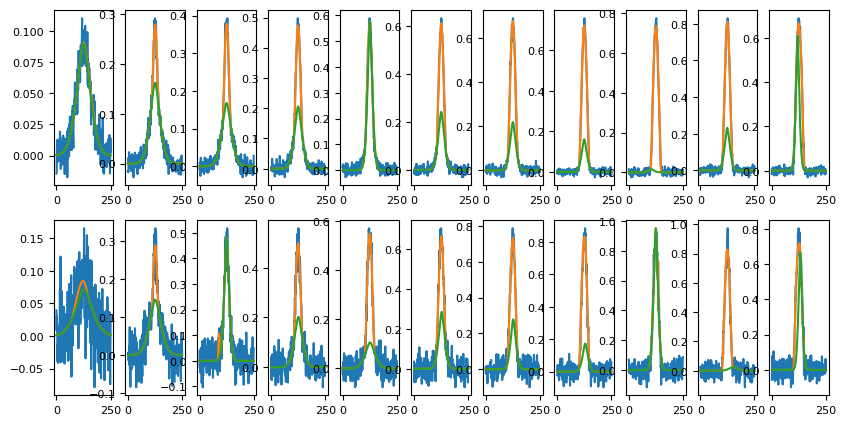

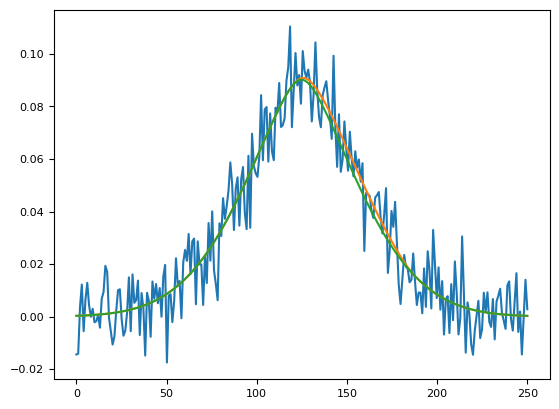

In [37]:
fsize= (10,5)
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        #lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        bval = result_x[i][j].best_values
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, **result_x[i][j].best_values))
        ax[i,j].plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))


plt.show()

bval = result_x[0][0].best_values
plt.plot(x, X_guess_og[0,0])
plt.plot(x, density_1d(x, **result_x[0][0].best_values))
plt.plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))
plt.show()


## 2D Fit without mathematical constraint

In [166]:
np.max(gaussian_filter(cropOD[1][1], sigma=1))
S = np.max(gaussian_filter(data, sigma=1))/(bval_1d['amp_bec'] + bval_1d['amp_th'])
print(S)

0.4358651483519299

In [19]:

result = []
result_1 = []
times = []
x = np.linspace(0,shape[3],cut_width)
y = np.linspace(0,shape[2], cut_width)

X,Y = np.meshgrid(x, y)
X_1d = X.flatten()
Y_1d = Y.flatten()

for i in range(0,shape[0]):
    temp_res_arr = []
    temp_res_arr_1 = []
    for j in range(0,shape[1]):
        print()
        print(f'image {i},{j}')
        data = cropOD[i,j]
        fitModel = lmfit.Model(density_profile_BEC_2d, independent_vars=['x','y'])
        #fitModel.set_param_hint('deltax', value=5)

        bval_1d = result_x[i][j].best_values
        print(bval_1d)

        S = np.max(gaussian_filter(data, sigma=1))/(bval_1d['amp_bec'] + bval_1d['amp_th'])
        params = lmfit.Parameters()
        #print(bval['sigma_th'])
        do_fit_2 = True
        if bval_1d['amp_th']/bval_1d['amp_bec'] > 4:
            print('Image seems to be purely thermal (guessed from 1d fit amplitude)')
            do_fit_2 = False
            params.add_many(
                ('amp_bec', 0, False, 0, 1.3 * np.max(data)),
                ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
                ('x0_bec',1, False),
                ('y0_bec',1, False),
                ('x0_th',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_th',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('sigmax_bec', 1, False),
                ('sigmay_bec', 1, False),
                ('sigma_th',bval_1d['sigma_th'], True, 0, cut_width)
            )

        elif bval_1d['amp_bec']/bval_1d['amp_th'] > 10:
            print('Image seems to be pure BEC (guessed from 1d fit amplitude)')
            do_fit_2 = False
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] - 10, center[i,j,1] + 10),
                ('x0_th', 1, False),
                ('y0_th', 1, False),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigma_th',bval_1d['sigma_th'], False, 0, 50)
            )



        else:
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('x0_th',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_th',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,1]),
                ('sigma_th',bval_1d['sigma_th'], True, 0, cut_width)
            )


        params.pretty_print()

        data1d = data.flatten()
        start = time.time()
        res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
        stop = time.time()
        temp_res_arr_1.append(res)


        # Check if there is an thermal part
        bval = res.best_values
        sigma_cut = max(bval['sigmay_bec'], bval['sigmax_bec'])
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut, sigmay=1.5*sigma_cut)


        mask = np.where(tf_fit > 0, np.nan, data)
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        mask = np.where(tf_fit_2 > 0, mask, np.nan)

        check_value = np.nansum(mask)

        print(f'time 1st fit: {stop-start :.3f} s')

        # if (check_value < 45) or ((check_value > 10000) and (bval['sigma_th'] < min(bval['sigmax_bec'], bval['sigmay_bec']))):
        #check_value = 200
        if check_value < 45 and do_fit_2:
            print('No thermal part detected, performing fit without thermal function')
            # if check_value > 200:
            #     print('Sigma Thermal smaller than BEC, but still strong part around masked region --> BEC guessed wrong')

            params = lmfit.Parameters()
            #print(bval['sigma_th'])
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] - 10, center[i,j,1] + 10),
                ('x0_th', 1, False),
                ('y0_th', 1, False),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigma_th',bval_1d['sigma_th'], False, 0, 50)
            )

            start2 = time.time()
            res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
            stop2 = time.time()

            print(f'time pure bec fit: {stop2-start2 :.3f} s')
            print('')
        stop2 = time.time()



        times.append(stop2-start)
        temp_res_arr.append(res)
    result_1.append(temp_res_arr_1)
    result.append(temp_res_arr)
times = np.array(times)
print(f"fitting time = {np.mean(times):.3f} +- {np.std(times, ddof=1):.3f}")
print(f"max fitting time = {np.max(times) :.3f}s")
print(times)




image 0,0
{'x0_bec': 142.00445054598697, 'x0_th': 124.28433053144651, 'amp_bec': 0.007373864322594913, 'amp_th': 0.0875248828973439, 'sigma_bec': 46.835962030049785, 'sigma_th': 38.73088055278765}
Image seems to be purely thermal (guessed from 1d fit amplitude)
Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec            0        0    0.402     None    False     None     None
amp_th        0.1352        0    0.402     None     True     None     None
sigma_th       38.73        0      250     None     True     None     None
sigmax_bec         1     -inf      inf     None    False     None     None
sigmay_bec         1     -inf      inf     None    False     None     None
x0_bec             1     -inf      inf     None    False     None     None
x0_th          124.1    114.1    134.1     None     True     None     None
y0_bec             1     -inf      inf     None    False     None     None
y0_th          124.3    114.3    134.3     None     True    

## Plotting

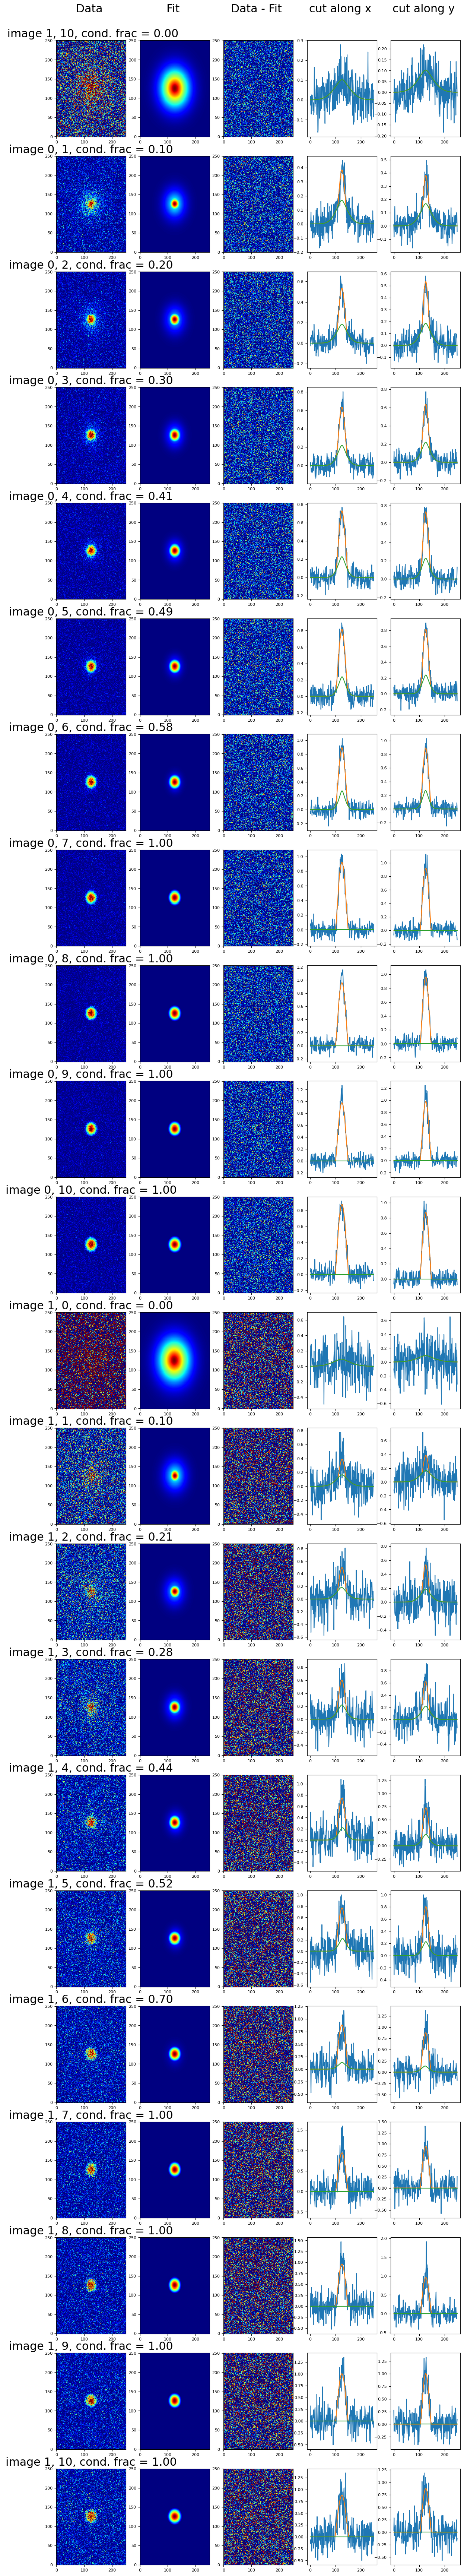

In [15]:
fig, axs = plt.subplots(shape[0] * shape[1], 5, figsize=(14, 4 * shape[0] * shape[1]),dpi = 100)

ii = 0
for i in range(0,shape[0]):

    for j in range(0,shape[1]):
        axs[ii,0].set_title(f'image {i}, {j}, cond. frac = {cond_frac(result[i][j]) :.2f}')
        lmfit.fit_report(result[i][j])
        bval = result[i][j].best_values
        fit = density_profile_BEC_2d(X,Y, **bval)
        vmax = np.max(fit)



        ax = axs[ii,0]
        ax.pcolormesh(X, Y, cropOD[i,j], vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')


        # Plot gaussian 2d Fit + legend including Width parameters
        ax = axs[ii,1]

        ax.pcolormesh(X, Y, fit, vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')

        ax = axs[ii,2]

        ax.pcolormesh(X, Y, fit-cropOD[i,j], vmin=0, vmax=0.2, cmap='jet', shading='auto')


        ax = axs[ii,3]

        ax.plot(x, cropOD[i,j, round(center[i,j,1]), :])
        ax.plot(x, fit[round(center[i,j,1]), :])
        ax.plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))

        ax = axs[ii,4]

        ax.plot(y, cropOD[i,j, :, round(center[i,j,0])])
        ax.plot(y, fit[:, round(center[i,j,0])])
        ax.plot(x, thermal(y, bval['y0_th'], bval['amp_th'], bval['sigma_th']))


        ii += 1

axs[0,0].set_title(f'Data \n \n image {i}, {j}, cond. frac = {cond_frac(result[0][0]) :.2f}')
axs[0,1].set_title('Fit \n \n')
axs[0,2].set_title('Data - Fit \n \n')
axs[0,3].set_title('cut along x \n \n')
axs[0,4].set_title('cut along y \n \n')



plt.show()

In [327]:
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        sx = result[i][j].best_values['sigmax_bec']
        sy = result[i][j].best_values['sigmay_bec']
        s_th = result[i][j].best_values['sigma_th']

        print(f'image {i}, {j}')
        print(f'FWHM_x BEC: { sx*1.22:.2f}, FWHM_x thermal: { s_th*1.93:.2f}')
        print(f'FWHM_y BEC: { sy*1.22:.2f}')
        print(f'Ratio fwhm_th/fwhm_bec: { 1/min(sx,sy)/1.22 * s_th *1.93 :.2f}')
        print('')

image 0, 0
FWHM_x BEC: 32.75, FWHM_x thermal: 74.38
FWHM_y BEC: 25.59
Ratio fwhm_th/fwhm_bec: 2.91

image 0, 1
FWHM_x BEC: 20.62, FWHM_x thermal: 54.05
FWHM_y BEC: 18.09
Ratio fwhm_th/fwhm_bec: 2.99

image 0, 2
FWHM_x BEC: 23.84, FWHM_x thermal: 49.32
FWHM_y BEC: 20.18
Ratio fwhm_th/fwhm_bec: 2.44

image 0, 3
FWHM_x BEC: 25.95, FWHM_x thermal: 41.75
FWHM_y BEC: 22.19
Ratio fwhm_th/fwhm_bec: 1.88

image 0, 4
FWHM_x BEC: 27.86, FWHM_x thermal: 37.63
FWHM_y BEC: 23.50
Ratio fwhm_th/fwhm_bec: 1.60

image 0, 5
FWHM_x BEC: 28.81, FWHM_x thermal: 34.44
FWHM_y BEC: 24.27
Ratio fwhm_th/fwhm_bec: 1.42

image 0, 6
FWHM_x BEC: 30.15, FWHM_x thermal: 29.43
FWHM_y BEC: 25.28
Ratio fwhm_th/fwhm_bec: 1.16

image 0, 7
FWHM_x BEC: 30.70, FWHM_x thermal: 25.68
FWHM_y BEC: 26.31
Ratio fwhm_th/fwhm_bec: 0.98

image 0, 8
FWHM_x BEC: 32.13, FWHM_x thermal: 19.48
FWHM_y BEC: 27.06
Ratio fwhm_th/fwhm_bec: 0.72

image 0, 9
FWHM_x BEC: 32.91, FWHM_x thermal: 17.25
FWHM_y BEC: 27.48
Ratio fwhm_th/fwhm_bec: 0.63



image 0, 0


type: 'numpy.ndarray' object is not callable

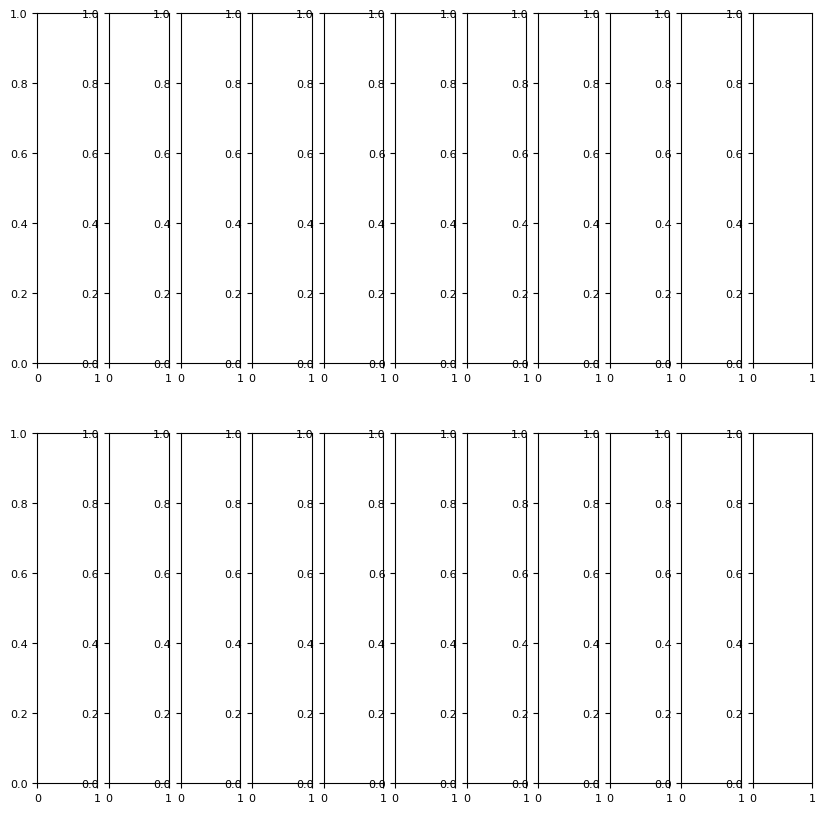

In [188]:
mask = np.zeros(shape)
mask2 = np.zeros(shape)
mask3 = []
fig, ax = plt.subplots(shape[0],shape[1], figsize=(10,10))

for i in range(0, shape[0]):
    temp_arr = []
    for j in range(0, shape[1]):
        print(f'image {i}, {j}')
        arr = []
        bval = result[i][j].best_values
        sigma_cut = max_val(bval['sigmay_bec'], bval['sigmax_bec'])
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut, sigmay=1.5* sigma_cut)


        mask[i,j] = np.where(tf_fit > 0, np.nan, cropOD[i,j])
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        #mask[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        mask2[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        # print(f'max = {np.nanmax(mask[i,j])}, {np.nanmax(mask[i,j]) / np.nanmin(mask[i,j])}')



        check_value = np.nanmean(mask2[i,j]) / (bval["amp_bec"] + bval["amp_th"])

        print(f'check val, {np.nansum(mask2[i,j])}')

        ax[i,j].pcolormesh(mask2[i,j], cmap='jet',vmin=0,vmax=0.5)

plt.show()

In [14]:
print_bval_bulk(result)


image: 0, 0
amp_bec: 0.000, (init = 0.000), bounds = [0.00 : 0.40] 
amp_th: 0.103, (init = 0.135), bounds = [0.00 : 0.40] 
x0_bec: 114.060, (init = 114.060), bounds = [114.06 : 134.06] 
y0_bec: 114.291, (init = 114.291), bounds = [114.29 : 134.29] 
x0_th: 125.454, (init = 124.060), bounds = [114.06 : 134.06] 
y0_th: 125.676, (init = 124.291), bounds = [114.29 : 134.29] 
sigmax_bec: 1.000, (init = 1.000), bounds = [0.00 : 95.08] 
sigmay_bec: 1.000, (init = 1.000), bounds = [0.00 : 72.13] 
sigma_th: 37.876, (init = 38.731), bounds = [0.00 : 250.00] 

image: 0, 1
amp_bec: 0.217, (init = 0.170), bounds = [0.00 : 0.72] 
amp_th: 0.169, (init = 0.229), bounds = [0.00 : 0.72] 
x0_bec: 125.205, (init = 123.226), bounds = [113.23 : 133.23] 
y0_bec: 126.138, (init = 126.090), bounds = [116.09 : 136.09] 
x0_th: 124.613, (init = 123.226), bounds = [113.23 : 133.23] 
y0_th: 126.036, (init = 126.090), bounds = [116.09 : 136.09] 
sigmax_bec: 16.903, (init = 15.416), bounds = [0.00 : 59.02] 
sigmay_bec

In [148]:
res = result[0][0]
print(res.init_params['amp_bec'].max)


def print_bval(result):
    keys = result.best_values.keys()
    bval = result.best_values
    init = result.init_params

    for item in keys:
        print(f'{item}: {bval[item]:.2f}, (init = {init[item].value:.2f}), bounds = [{init[item].min:.2f} : {init[item].max :.2f}] ')

print_bval(res)

0.40202012547790794
amp_bec: 0.01, (init = 0.01), bounds = [0.00 : 0.40] 
amp_th: 0.10, (init = 0.24), bounds = [0.00 : 0.40] 
x0_bec: 124.50, (init = 124.06), bounds = [114.06 : 134.06] 
y0_bec: 115.07, (init = 124.29), bounds = [114.29 : 134.29] 
x0_th: 125.46, (init = 124.06), bounds = [114.06 : 134.06] 
y0_th: 125.96, (init = 124.29), bounds = [114.29 : 134.29] 
sigmax_bec: 79.34, (init = 47.78), bounds = [0.00 : 95.99] 
sigmay_bec: 3.97, (init = 48.09), bounds = [0.00 : 96.17] 
sigma_th: 38.05, (init = 38.77), bounds = [0.00 : 250.00] 


In [82]:
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        print(f'image {i}, {j}')
        bval = result[i][j].best_values

        print(f"sigmax = {bval['sigmax_bec']}, sigmay = {bval['sigmay_bec']} ")
        print(result_x[i][j].best_values['sigma_bec'])
        print(BEC_width_guess[i,j] /1.22)

image 0, 0
sigmax = 26.809654363723393, sigmay = 20.984865705907357 
49.68707529159811
[47.99635701 48.08743169]
image 0, 1
sigmax = 16.902431605565432, sigmay = 14.827716571560885 
15.654987743234889
[28.50637523 25.50091075]
image 0, 2
sigmax = 19.537062472446536, sigmay = 16.54490141361424 
18.026074303206485
[27.32240437 23.67941712]
image 0, 3
sigmax = 21.26943188775151, sigmay = 18.18988358733591 
19.556767700963444
[27.23132969 23.86156648]
image 0, 4
sigmax = 22.839337165618247, sigmay = 19.260967695867635 
20.90144486963491
[27.77777778 23.86156648]
image 0, 5
sigmax = 23.611867762365737, sigmay = 19.890208925283233 
21.630994243513612
[28.77959927 24.49908925]
image 0, 6
sigmax = 24.715898892965207, sigmay = 20.72301092040907 
22.830805825494014
[28.50637523 24.7723133 ]
image 0, 7
sigmax = 25.37740108909912, sigmay = 22.34732657140245 
23.78148211266294
[28.68852459 25.31876138]
image 0, 8
sigmax = 25.54988097917328, sigmay = 22.05819714419466 
24.633548951333726
[28.1420765

In [173]:
print_bval_bulk(result_1)

image: 0, 0
amp_bec: 0.000, (init = 0.000), bounds = [0.00 : 0.40] 
amp_th: 0.103, (init = 0.138), bounds = [0.00 : 0.40] 
x0_bec: 114.060, (init = 114.060), bounds = [114.06 : 134.06] 
y0_bec: 114.291, (init = 114.291), bounds = [114.29 : 134.29] 
x0_th: 125.454, (init = 124.060), bounds = [114.06 : 134.06] 
y0_th: 125.676, (init = 124.291), bounds = [114.29 : 134.29] 
sigmax_bec: 1.000, (init = 1.000), bounds = [0.00 : 95.99] 
sigmay_bec: 1.000, (init = 1.000), bounds = [0.00 : 96.17] 
sigma_th: 37.876, (init = 38.769), bounds = [0.00 : 250.00] 

image: 0, 1
amp_bec: 0.217, (init = 0.168), bounds = [0.00 : 0.72] 
amp_th: 0.169, (init = 0.230), bounds = [0.00 : 0.72] 
x0_bec: 125.205, (init = 123.226), bounds = [113.23 : 133.23] 
y0_bec: 126.138, (init = 126.090), bounds = [116.09 : 136.09] 
x0_th: 124.613, (init = 123.226), bounds = [113.23 : 133.23] 
y0_th: 126.037, (init = 126.090), bounds = [116.09 : 136.09] 
sigmax_bec: 16.902, (init = 15.655), bounds = [0.00 : 57.01] 
sigmay_bec

In [37]:
result_x[1][0].best_values['sigma_th']

111.52339962118164

image 0, 0
check val, 0.0
image 0, 1
check val, 202.81899317348075
image 0, 2
check val, 171.66227694315586
image 0, 3
check val, 137.86010387483958
image 0, 4
check val, 112.63334115900692
image 0, 5
check val, 80.32146811618618
image 0, 6
check val, 47.14137119721544
image 0, 7
check val, 20.13939399629303
image 0, 8
check val, 7.729201970644159
image 0, 9
check val, -0.24707647603264393
image 0, 10
check val, -10.485648818860035
image 1, 0
check val, 0.0
image 1, 1
check val, 155.40174729200504
image 1, 2
check val, 267.84199180102325


C:\Users\Jianshun Gao\AppData\Local\Temp\ipykernel_36888\2144014449.py:109: RuntimeWarning: invalid value encountered in power
  res = np.where(res > 0, res**(3/2), 0)
C:\Users\Jianshun Gao\AppData\Local\Temp\ipykernel_36888\737382478.py:25: RuntimeWarning: Mean of empty slice
  check_value = np.nanmean(mask2[i,j]) / (bval["amp_bec"] + bval["amp_th"])


image 1, 3
check val, 134.5222938744657
image 1, 4
check val, 90.07549048132266
image 1, 5
check val, 109.52459360079988
image 1, 6
check val, 63.76264252044428
image 1, 7
check val, 75.0924950611463
image 1, 8
check val, 29.827565402107858
image 1, 9
check val, -0.20590658874586376
image 1, 10
check val, 3.7193052125950476


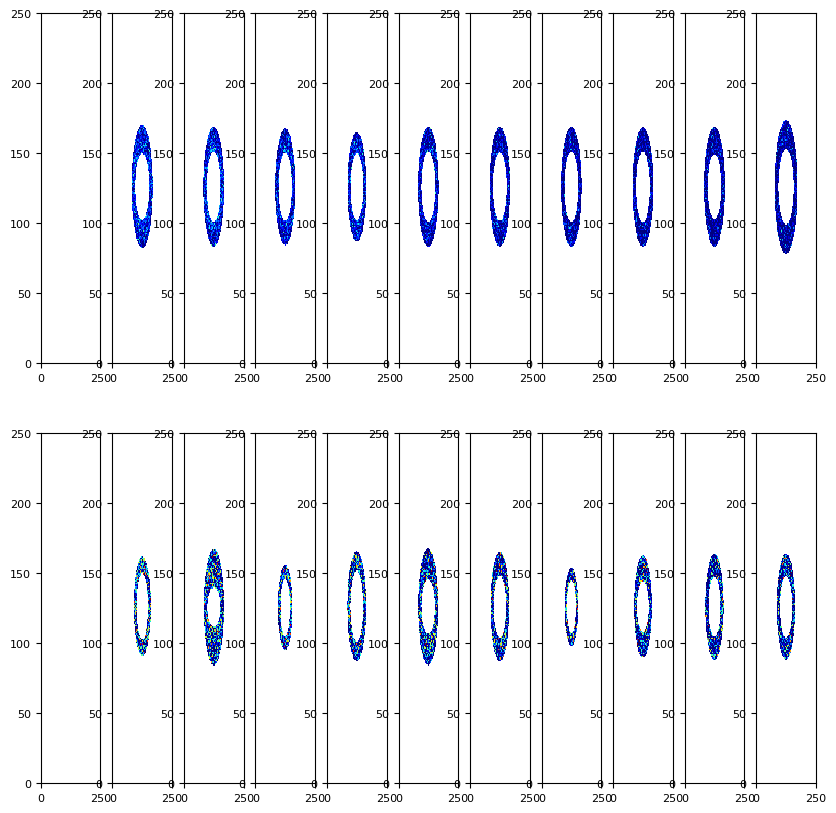

In [189]:
mask = np.zeros(shape)
mask2 = np.zeros(shape)
mask3 = []
fig, ax = plt.subplots(shape[0],shape[1], figsize=(10,10))

for i in range(0, shape[0]):
    temp_arr = []
    for j in range(0, shape[1]):
        print(f'image {i}, {j}')
        arr = []
        bval = result[i][j].best_values
        sigma_cut = max(BEC_width_guess[i,j,0], BEC_width_guess[i,j,1])
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=BEC_width_guess[i,j,0]/1.22, sigmay=BEC_width_guess[i,j,1]/1.22)
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut/1.22, sigmay=1.5* sigma_cut/1.22)


        mask[i,j] = np.where(tf_fit > 0, np.nan, cropOD[i,j])
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        #mask[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        mask2[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        # print(f'max = {np.nanmax(mask[i,j])}, {np.nanmax(mask[i,j]) / np.nanmin(mask[i,j])}')



        check_value = np.nanmean(mask2[i,j]) / (bval["amp_bec"] + bval["amp_th"])

        print(f'check val, {np.nansum(mask2[i,j])}')

        ax[i,j].pcolormesh(mask2[i,j], cmap='jet',vmin=0,vmax=0.5)

plt.show()

In [18]:
cropOD[0][0]

array([[ 0.07268155, -0.09124867,  0.11122564, ...,  0.09485779,
         0.04357125,  0.02711324],
       [ 0.09737416,  0.01287571,  0.04367506, ...,  0.04072961,
        -0.04108686, -0.02136833],
       [ 0.17652024,  0.05190786,  0.02469261, ...,  0.06313304,
        -0.01336323, -0.02586351],
       ...,
       [-0.11633899, -0.0156079 , -0.01670185, ...,  0.03050345,
         0.01282069,  0.06573208],
       [ 0.07503519, -0.00413224, -0.00858374, ..., -0.02333086,
         0.06368782,  0.03050345],
       [-0.08058049,  0.01200014,  0.02309571, ...,  0.05032508,
        -0.10199917, -0.00209424]])